# Universidade de Fortaleza
## Mestrado em Informática Aplicada
### Ciência de Dados aplicada à Ciência da Cidade

# Final Assignment: Optimal Placement of Government Services in Ceará

## Objective

This notebook applies urban data science concepts to determine optimal placement of government services or private businesses in Ceará municipalities, using socioeconomic metrics from IPEADATA.

## Course Concepts Applied

1. **Zipf's Law** - City size distributions for understanding population hierarchy
2. **Voronoi Diagrams** - Service area allocation and coverage analysis
3. **Scaling Laws (β exponent)** - Resource allocation based on population scaling
4. **Gravity Models** - Distance decay effects on accessibility

## Data Sources

- **IPEADATA** (http://www.ipeadata.gov.br/) - Socioeconomic data by municipality
- **IBGE** - Geographic coordinates and municipal boundaries
- **Municípios Brasileiros Dataset** - Latitude/longitude for all municipalities

---
## 1. Setup and Imports

In [6]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geospatial
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from scipy.optimize import minimize

# Optional: for maps
# import folium
# import geopandas as gpd

# IPEADATA API wrapper
# pip install ipeadatapy
# import ipeadatapy as ipea

plt.style.use('seaborn-v0_8-whitegrid')

---
## 2. Data Loading

### 2.1 Load Ceará Municipalities with Population and Coordinates

We'll use the existing population data from 02-zipf and add geographic coordinates.

In [7]:
# Load population data from existing zipf analysis
df_pop = pd.read_csv("../02-zipf/ceara_cities.csv", skiprows=1)
df_pop.columns = [c.strip().replace("\ufeff", "") for c in df_pop.columns]

# Rename columns for clarity
df_pop = df_pop.rename(columns={"Código": "code", "Município": "city", "2022": "population"})
df_pop["population"] = pd.to_numeric(df_pop["population"], errors="coerce")
df_pop = df_pop.dropna(subset=["population"])
df_pop = df_pop[df_pop["population"] > 0]

print(f"Loaded {len(df_pop)} municipalities from Ceará")
df_pop.head()

Loaded 184 municipalities from Ceará


,Sigla,code,city,population,Unnamed: 4
0,CE,2300101,Abaiara,10038.0,NaN
1,CE,2300150,Acarapé,14027.0,NaN
2,CE,2300200,Acaraú,65264.0,NaN
3,CE,2300309,Acopiara,44962.0,NaN
4,CE,2300408,Aiuaba,14076.0,NaN


In [8]:
# Load geographic coordinates
# Data source: https://github.com/kelvins/Municipios-Brasileiros
# Download CSV with lat/long for Brazilian municipalities

# Option 1: Download from GitHub
url_coords = "https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv"
df_coords = pd.read_csv(url_coords)

# Filter for Ceará (UF code 23)
df_coords_ce = df_coords[df_coords["codigo_uf"] == 23].copy()
df_coords_ce = df_coords_ce.rename(columns={"codigo_ibge": "code", "nome": "city_name", 
                                             "latitude": "lat", "longitude": "lon"})

print(f"Loaded coordinates for {len(df_coords_ce)} Ceará municipalities")
df_coords_ce.head()

Loaded coordinates for 184 Ceará municipalities


,code,city_name,lat,lon,capital,codigo_uf,siafi_id,ddd,fuso_horario
5,2300101,Abaiara,-7.34588,-39.0416,0,23,1301,88,America/Sao_Paulo
19,2300150,Acarape,-4.22083,-38.7055,0,23,1231,85,America/Sao_Paulo
20,2300200,Acaraú,-2.88769,-40.1183,0,23,1303,88,America/Sao_Paulo
24,2300309,Acopiara,-6.08911,-39.4480,0,23,1305,88,America/Sao_Paulo
83,2300408,Aiuaba,-6.57122,-40.1178,0,23,1307,88,America/Sao_Paulo


In [9]:
# Merge population and coordinates
df = df_pop.merge(df_coords_ce[["code", "lat", "lon"]], on="code", how="inner")
print(f"Merged dataset: {len(df)} municipalities with population and coordinates")
df.head()

Merged dataset: 184 municipalities with population and coordinates


,Sigla,code,city,population,Unnamed: 4,lat,lon
0,CE,2300101,Abaiara,10038.0,NaN,-7.34588,-39.0416
1,CE,2300150,Acarapé,14027.0,NaN,-4.22083,-38.7055
2,CE,2300200,Acaraú,65264.0,NaN,-2.88769,-40.1183
3,CE,2300309,Acopiara,44962.0,NaN,-6.08911,-39.4480
4,CE,2300408,Aiuaba,14076.0,NaN,-6.57122,-40.1178


### 2.2 Load Socioeconomic Data from IPEADATA

We'll fetch employment/unemployment or other relevant metrics.

In [ ]:
# Using ipeadatapy to explore available series
# import ipeadatapy as ipea

# List available regional series
# series = ipea.list_series()
# regional_series = series[series['SERNOME'].str.contains('municipal', case=False, na=False)]
# print(regional_series[['SERCODIGO', 'SERNOME']].head(20))

# For now, we'll use population as the primary metric
# and can add IDHM, PIB per capita, or employment data later

---
## 3. Exploratory Analysis

### 3.1 Visualize Municipality Distribution

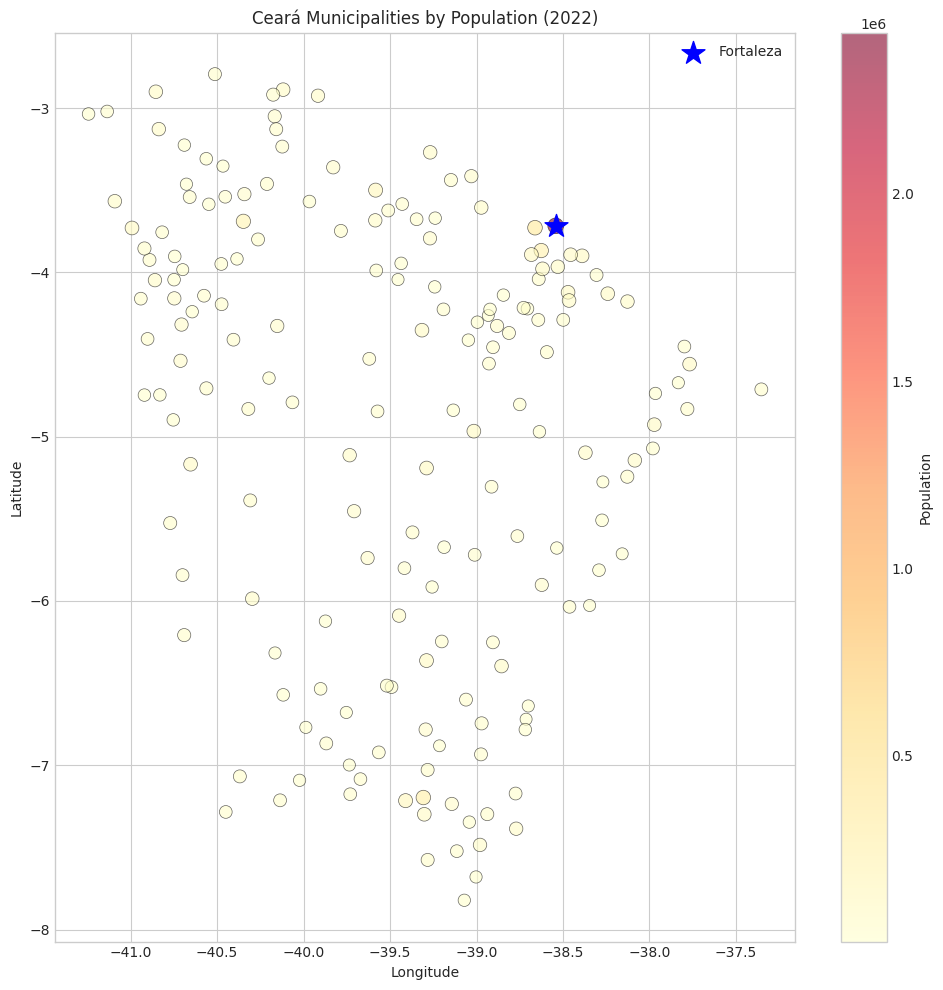

In [10]:
# Plot municipalities on a map
fig, ax = plt.subplots(figsize=(10, 10))

# Size points by population (log scale for visibility)
sizes = np.log10(df["population"]) * 20

scatter = ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.6, 
                     c=df["population"], cmap="YlOrRd", edgecolors="black", linewidth=0.5)

# Highlight Fortaleza
fortaleza = df[df["city"] == "Fortaleza"]
if len(fortaleza) > 0:
    ax.scatter(fortaleza["lon"], fortaleza["lat"], s=300, c="blue", 
               marker="*", label="Fortaleza", zorder=5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Ceará Municipalities by Population (2022)")
plt.colorbar(scatter, label="Population")
ax.legend()
plt.tight_layout()
plt.show()

### 3.2 Apply Zipf's Law Analysis

Review the population hierarchy to understand city size distribution.

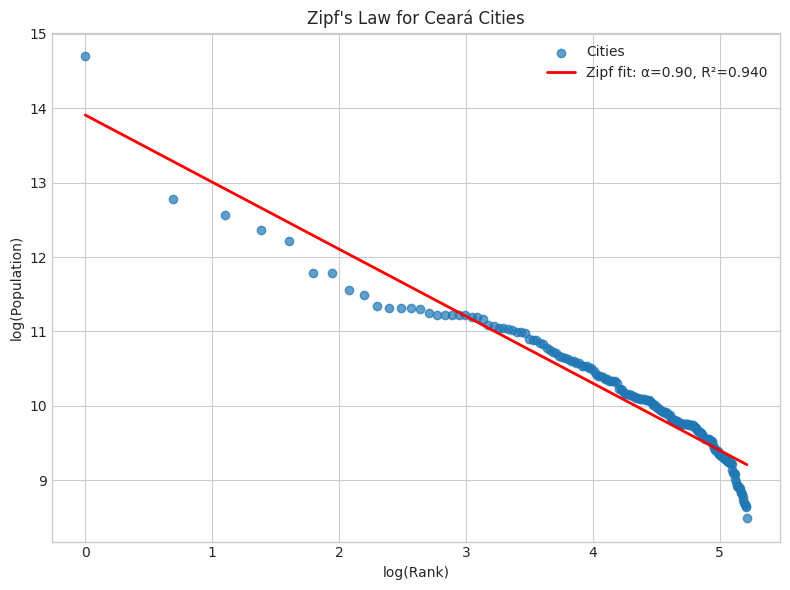

Zipf exponent α = 0.901
Top 5 cities: ['Fortaleza', 'Caucaia', 'Juazeiro do Norte', 'Maracanaú', 'Sobral']


In [11]:
# Rank cities by population
df_ranked = df.sort_values(by="population", ascending=False).reset_index(drop=True)
df_ranked["rank"] = np.arange(1, len(df_ranked) + 1)

# Log-log regression
x = np.log(df_ranked["rank"])
y = np.log(df_ranked["population"])

slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

# R²
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2 = 1 - ss_res / ss_tot

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label="Cities")
plt.plot(x, y_pred, color="red", linewidth=2, label=f"Zipf fit: α={-slope:.2f}, R²={r2:.3f}")
plt.xlabel("log(Rank)")
plt.ylabel("log(Population)")
plt.title("Zipf's Law for Ceará Cities")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Zipf exponent α = {-slope:.3f}")
print(f"Top 5 cities: {df_ranked['city'].head().tolist()}")

---
## 4. Service Placement Problem

### Problem Definition

Given $n$ municipalities with:
- Coordinates $(x_i, y_i)$
- Population $P_i$
- (Optional) Socioeconomic need metric $N_i$

Find optimal locations for $k$ service centers that minimize weighted distance to the population.

### Approaches

1. **Population-weighted centroid** - Single facility location
2. **k-means weighted by population** - Multiple facility location
3. **Gravity model optimization** - Account for distance decay
4. **Voronoi analysis** - Assess current vs optimal coverage

### 4.1 Population-Weighted Centroid

Find the single point that minimizes total weighted distance.

In [12]:
def weighted_centroid(df):
    """Calculate population-weighted centroid."""
    total_pop = df["population"].sum()
    weighted_lat = (df["lat"] * df["population"]).sum() / total_pop
    weighted_lon = (df["lon"] * df["population"]).sum() / total_pop
    return weighted_lat, weighted_lon

centroid_lat, centroid_lon = weighted_centroid(df)
print(f"Population-weighted centroid: ({centroid_lat:.4f}, {centroid_lon:.4f})")

# Find nearest city to centroid
df["dist_to_centroid"] = np.sqrt((df["lat"] - centroid_lat)**2 + (df["lon"] - centroid_lon)**2)
nearest_city = df.loc[df["dist_to_centroid"].idxmin()]
print(f"Nearest city to centroid: {nearest_city['city']}")

Population-weighted centroid: (-4.4959, -39.1458)
Nearest city to centroid: Aratuba


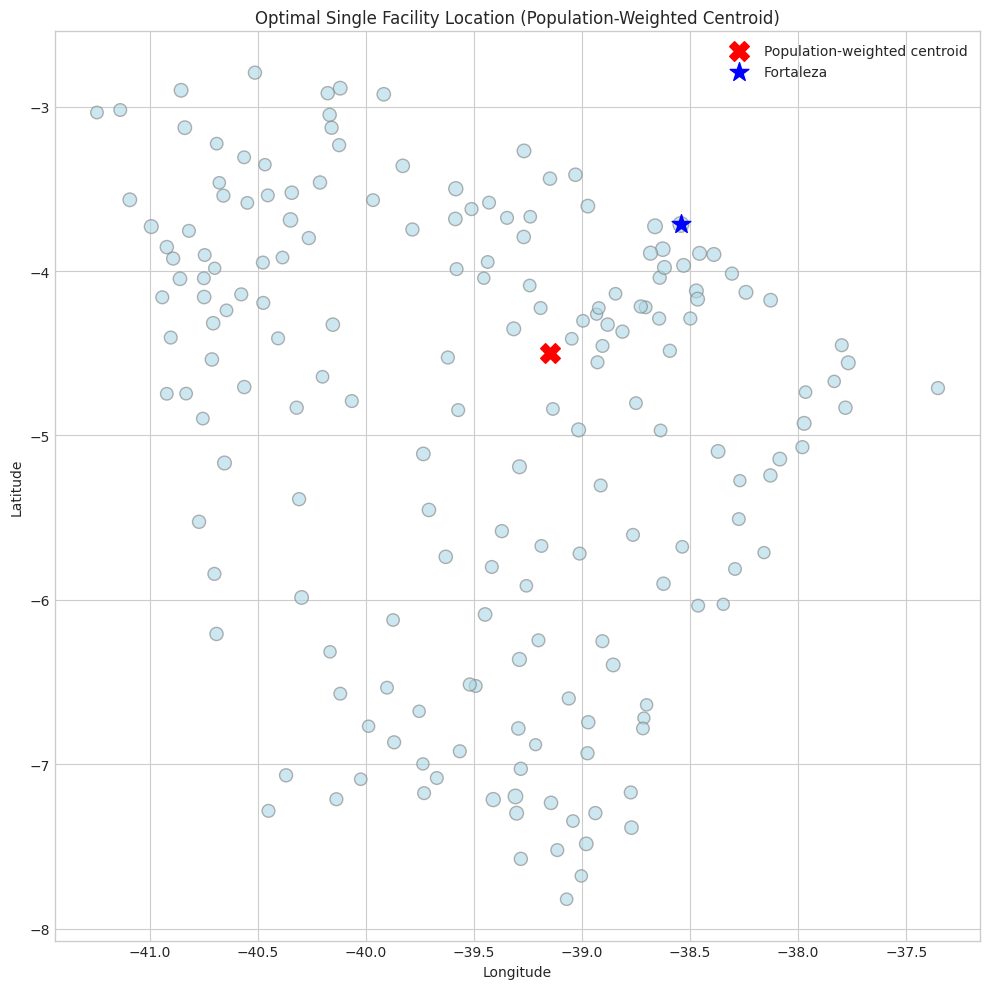

In [13]:
# Visualize centroid
fig, ax = plt.subplots(figsize=(10, 10))

sizes = np.log10(df["population"]) * 20
ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.6, c="lightblue", edgecolors="gray")

# Mark centroid
ax.scatter(centroid_lon, centroid_lat, s=200, c="red", marker="X", 
           label="Population-weighted centroid", zorder=5)

# Mark Fortaleza for reference
fortaleza = df[df["city"] == "Fortaleza"]
if len(fortaleza) > 0:
    ax.scatter(fortaleza["lon"], fortaleza["lat"], s=200, c="blue", 
               marker="*", label="Fortaleza", zorder=5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Optimal Single Facility Location (Population-Weighted Centroid)")
ax.legend()
plt.tight_layout()
plt.show()

### 4.2 Weighted K-Means for Multiple Facilities

Find $k$ optimal locations for service centers.

In [21]:
def weighted_kmeans(df, k, max_iter=100):
    """
    Population-weighted k-means clustering.
    Each iteration assigns cities to nearest center, then recalculates
    centers as population-weighted centroids of assigned cities.
    """
    np.random.seed(42)
    coords = df[["lat", "lon"]].values
    weights = df["population"].values
    
    # Initialize centers from random cities (weighted by population)
    probs = weights / weights.sum()
    initial_idx = np.random.choice(len(df), size=k, replace=False, p=probs)
    centers = coords[initial_idx].copy()
    
    for iteration in range(max_iter):
        # Assign each city to nearest center
        distances = cdist(coords, centers)
        assignments = np.argmin(distances, axis=1)
        
        # Recalculate centers as weighted centroids
        new_centers = np.zeros_like(centers)
        for c in range(k):
            mask = assignments == c
            if mask.sum() > 0:
                cluster_weights = weights[mask]
                total_weight = cluster_weights.sum()
                new_centers[c] = (coords[mask] * cluster_weights[:, np.newaxis]).sum(axis=0) / total_weight
            else:
                new_centers[c] = centers[c]  # Keep old center if no assignments
        
        # Check convergence
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    
    return centers, assignments

# Find 5 optimal locations
k = 10
centers, assignments = weighted_kmeans(df, k)
print(f"Found {k} optimal facility locations:")
for i, (lat, lon) in enumerate(centers):
    # Find nearest city
    distances = np.sqrt((df["lat"] - lat)**2 + (df["lon"] - lon)**2)
    nearest = df.loc[distances.idxmin(), "city"]
    pop_served = df[assignments == i]["population"].sum()
    print(f"  Center {i+1}: ({lat:.4f}, {lon:.4f}) - nearest: {nearest}, pop served: {pop_served:,}")

Found 10 optimal facility locations:
  Center 1: (-3.7329, -38.5738) - nearest: Fortaleza, pop served: 3,178,132.0
  Center 2: (-5.2715, -40.5468) - nearest: Crateús, pop served: 395,485.0
  Center 3: (-4.3820, -39.0981) - nearest: Aratuba, pop served: 296,903.0
  Center 4: (-4.9633, -38.0083) - nearest: Russas, pop served: 459,476.0
  Center 5: (-3.4996, -39.5042) - nearest: Itapipoca, pop served: 562,172.0
  Center 6: (-7.2110, -39.3388) - nearest: Juazeiro do Norte, pop served: 992,826.0
  Center 7: (-5.3135, -39.3080) - nearest: Quixeramobim, pop served: 429,541.0
  Center 8: (-3.6085, -40.5780) - nearest: Alcântaras, pop served: 1,274,325.0
  Center 9: (-4.0748, -38.4582) - nearest: Horizonte, pop served: 728,566.0
  Center 10: (-6.3553, -39.1749) - nearest: Quixelô, pop served: 477,531.0


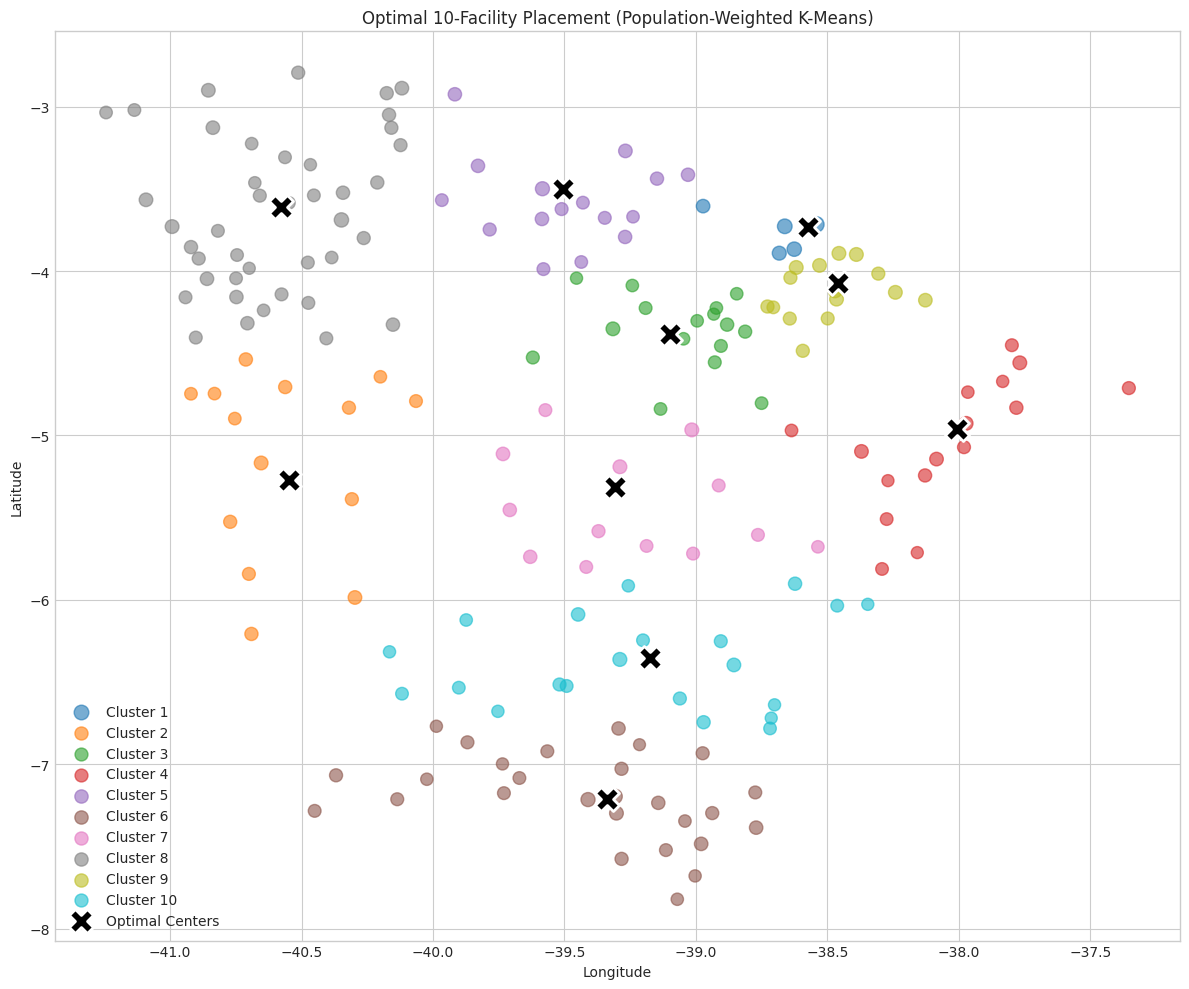

In [22]:
# Visualize k-means results
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.tab10(np.linspace(0, 1, k))
sizes = np.log10(df["population"]) * 20

for i in range(k):
    mask = assignments == i
    ax.scatter(df.loc[mask, "lon"], df.loc[mask, "lat"], 
               s=sizes[mask], alpha=0.6, c=[colors[i]], label=f"Cluster {i+1}")

# Mark centers
ax.scatter(centers[:, 1], centers[:, 0], s=300, c="black", marker="X", 
           edgecolors="white", linewidth=2, label="Optimal Centers", zorder=5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Optimal {k}-Facility Placement (Population-Weighted K-Means)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

### 4.3 Voronoi Diagram Analysis

Analyze service areas using Voronoi tessellation.

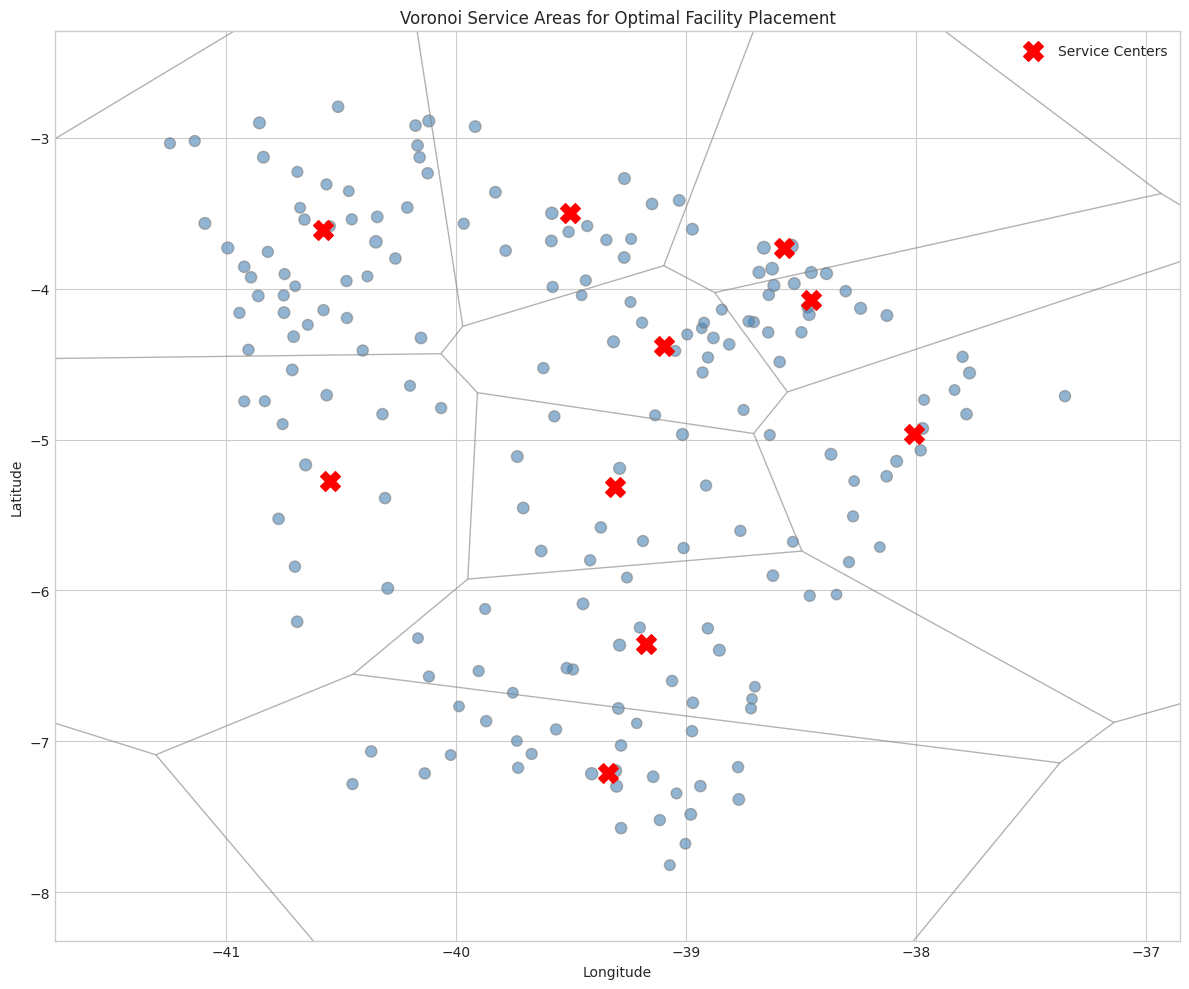

In [23]:
# Create Voronoi diagram from optimal centers
# Note: Voronoi needs at least 3 points and works best with more
from scipy.spatial import Voronoi, voronoi_plot_2d

# Use (lon, lat) for Voronoi (x, y order)
center_points = np.column_stack([centers[:, 1], centers[:, 0]])  # (lon, lat)

# Add boundary points to close the Voronoi regions
lon_min, lon_max = df["lon"].min() - 1, df["lon"].max() + 1
lat_min, lat_max = df["lat"].min() - 1, df["lat"].max() + 1

boundary_points = np.array([
    [lon_min, lat_min], [lon_min, lat_max],
    [lon_max, lat_min], [lon_max, lat_max]
])

all_points = np.vstack([center_points, boundary_points])
vor = Voronoi(all_points)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray', 
                line_width=1, line_alpha=0.6, point_size=0)

# Plot cities
sizes = np.log10(df["population"]) * 15
ax.scatter(df["lon"], df["lat"], s=sizes, alpha=0.6, c="steelblue", edgecolors="gray")

# Plot centers
ax.scatter(center_points[:, 0], center_points[:, 1], s=200, c="red", 
           marker="X", label="Service Centers", zorder=5)

ax.set_xlim(lon_min + 0.5, lon_max - 0.5)
ax.set_ylim(lat_min + 0.5, lat_max - 0.5)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Voronoi Service Areas for Optimal Facility Placement")
ax.legend()
plt.tight_layout()
plt.show()

### 4.4 Gravity Model Analysis

Apply distance decay to understand accessibility patterns.

The gravity model states that the "attraction" between a service and a population decreases with distance:

$$A_{ij} = \frac{P_i \cdot S_j}{d_{ij}^\beta}$$

Where:
- $P_i$ = population of city $i$
- $S_j$ = "size" of service at location $j$
- $d_{ij}$ = distance between $i$ and $j$
- $\beta$ = distance decay exponent (typically 1-2)

In [24]:
def calculate_accessibility(df, service_locations, beta=1.5, d0=0.1):
    """
    Calculate accessibility score for each city based on gravity model.
    Higher score = better access to services.
    """
    coords = df[["lat", "lon"]].values
    accessibility = np.zeros(len(df))
    
    for service_lat, service_lon in service_locations:
        distances = np.sqrt((df["lat"] - service_lat)**2 + (df["lon"] - service_lon)**2)
        # Avoid division by zero
        distances = np.maximum(distances, d0)
        accessibility += 1 / (distances ** beta)
    
    return accessibility

# Calculate accessibility with current optimal centers
df["accessibility"] = calculate_accessibility(df, centers)

# Normalize to 0-100 scale
df["accessibility_norm"] = (df["accessibility"] - df["accessibility"].min()) / \
                           (df["accessibility"].max() - df["accessibility"].min()) * 100

print("Accessibility Statistics:")
print(f"  Min: {df['accessibility_norm'].min():.1f}")
print(f"  Max: {df['accessibility_norm'].max():.1f}")
print(f"  Mean: {df['accessibility_norm'].mean():.1f}")
print(f"  Median: {df['accessibility_norm'].median():.1f}")

# Cities with lowest accessibility
print("\nCities with lowest accessibility:")
print(df.nsmallest(10, "accessibility_norm")[["city", "population", "accessibility_norm"]])

Accessibility Statistics:
  Min: 0.0
  Max: 100.0
  Mean: 24.7
  Median: 15.5

Cities with lowest accessibility:
                       city  population  accessibility_norm
156                 Salitre     16633.0            0.000000
45                   Chaval     12462.0            0.702926
32             Campos Sales     25135.0            1.047724
25              Barroquinha     14567.0            1.344101
137               Penaforte      8972.0            2.099773
31                  Camocim     62326.0            2.231697
15                  Araripe     19783.0            2.259375
134                 Parambu     31445.0            2.467021
97   Jijoca de Jericoacoara     25555.0            2.629355
96                     Jati      7861.0            3.722012


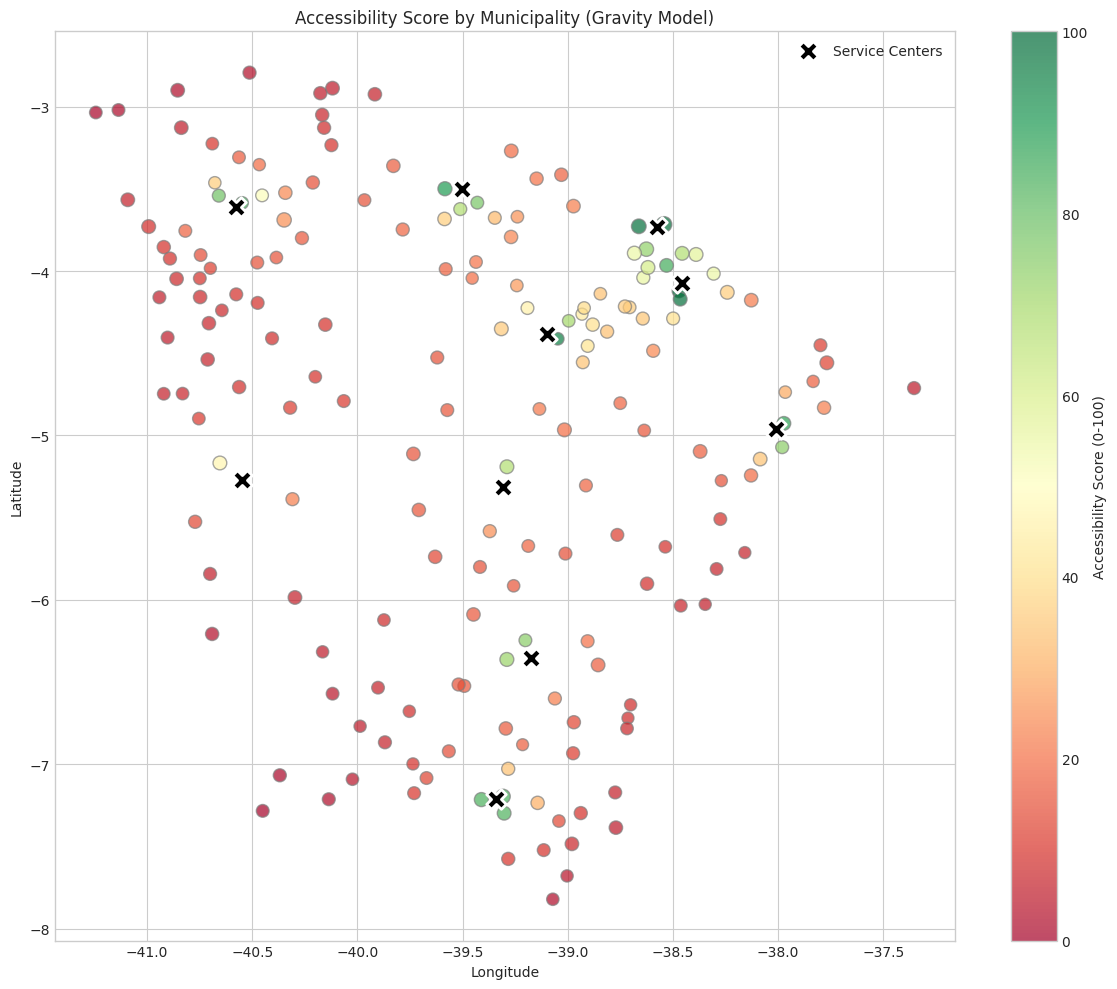

In [25]:
# Visualize accessibility
fig, ax = plt.subplots(figsize=(12, 10))

sizes = np.log10(df["population"]) * 20
scatter = ax.scatter(df["lon"], df["lat"], s=sizes, c=df["accessibility_norm"], 
                     cmap="RdYlGn", alpha=0.7, edgecolors="gray")

# Mark centers
ax.scatter(centers[:, 1], centers[:, 0], s=200, c="black", marker="X", 
           edgecolors="white", linewidth=2, label="Service Centers", zorder=5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Accessibility Score by Municipality (Gravity Model)")
plt.colorbar(scatter, label="Accessibility Score (0-100)")
ax.legend()
plt.tight_layout()
plt.show()

---
## 5. Scaling Law Application

Use the β exponent from scaling laws to determine resource allocation proportional to population.

In [19]:
def allocate_resources(df, total_budget, beta=1.0):
    """
    Allocate resources based on population scaling law.
    
    If beta = 1: linear allocation (proportional to population)
    If beta > 1: superlinear (larger cities get more per capita)
    If beta < 1: sublinear (smaller cities get more per capita)
    """
    scaled_pop = df["population"] ** beta
    allocation = (scaled_pop / scaled_pop.sum()) * total_budget
    return allocation

# Compare different scaling exponents
total_budget = 100_000_000  # R$ 100 million

for beta in [0.8, 1.0, 1.2]:
    df[f"allocation_beta_{beta}"] = allocate_resources(df, total_budget, beta)
    df[f"per_capita_beta_{beta}"] = df[f"allocation_beta_{beta}"] / df["population"]

# Show top 10 cities allocation
print("Resource Allocation for Top 10 Cities by Population:")
print(df.nlargest(10, "population")[["city", "population", 
                                      "allocation_beta_0.8", "allocation_beta_1.0", "allocation_beta_1.2"]])

Resource Allocation for Top 10 Cities by Population:
                  city  population  allocation_beta_0.8  allocation_beta_1.0  \
58           Fortaleza   2428708.0         1.489119e+07         2.761478e+07   
43             Caucaia    355679.0         3.202401e+06         4.044124e+06   
98   Juazeiro do Norte    286120.0         2.690715e+06         3.253228e+06   
103          Maracanaú    234509.0         2.294863e+06         2.666403e+06   
166             Sobral    203023.0         2.044868e+06         2.308402e+06   
87           Itapipoca    131123.0         1.441359e+06         1.490888e+06   
50               Crato    131050.0         1.440717e+06         1.490058e+06   
104         Maranguape    105093.0         1.207503e+06         1.194923e+06   
76              Iguatu     98064.0         1.142449e+06         1.115003e+06   
148            Quixadá     84168.0         1.010990e+06         9.570030e+05   

     allocation_beta_1.2  
58          4.443737e+07  
43          

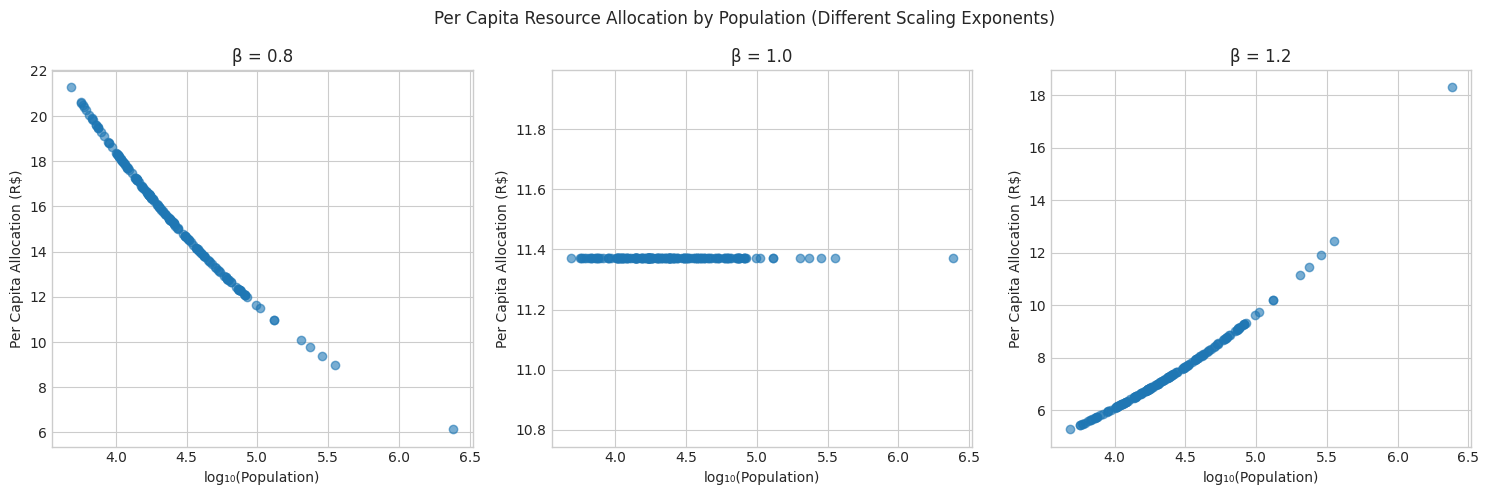

In [20]:
# Compare per-capita allocation across different beta values
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, beta in enumerate([0.8, 1.0, 1.2]):
    ax = axes[i]
    ax.scatter(np.log10(df["population"]), df[f"per_capita_beta_{beta}"], alpha=0.6)
    ax.set_xlabel("log₁₀(Population)")
    ax.set_ylabel("Per Capita Allocation (R$)")
    ax.set_title(f"β = {beta}")
    ax.grid(True)

plt.suptitle("Per Capita Resource Allocation by Population (Different Scaling Exponents)")
plt.tight_layout()
plt.show()

---
## 6. Conclusions and Recommendations

### Key Findings

1. **Population Distribution**: Ceará follows Zipf's Law with exponent α ≈ ...

2. **Optimal Locations**: The k-means analysis identified optimal service center locations that minimize population-weighted distances.

3. **Accessibility Gaps**: Cities with lowest accessibility scores represent priority areas for service expansion.

4. **Resource Allocation**: Different scaling exponents (β) significantly impact per-capita allocation, favoring either large urban centers (β > 1) or smaller municipalities (β < 1).

### Recommendations

1. Consider placing new government services near the identified optimal center locations.

2. Prioritize low-accessibility municipalities for service expansion.

3. Use sublinear scaling (β < 1) for equity-focused resource allocation.

---
## References

- IPEADATA: http://www.ipeadata.gov.br/
- IBGE: https://www.ibge.gov.br/
- Municípios Brasileiros Dataset: https://github.com/kelvins/Municipios-Brasileiros
- ipeadatapy documentation: https://www.luanborelli.net/ipeadatapy/docs/